## Imports:

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from random import randint

# -----------------------------------------------------------------------------------------------------------------

## Environment Parameters:

In [2]:
#Time-step
del_t = 0.01

#Friction coefficient between slider and surface:
mu1 = 0.3

#Friction coefficient between gripper and slider:
mu2 = 0.1

#Block dimensions:
length = 0.3
breadth = 0.1
height = 0.1

#Mass of block in kg:
mass = 0.2

#Moment of Inertia (Cuboid here):
Iz = (mass * (length**2 + breadth**2)) / 12

#Friction:
Fr = mu1 * mass * 9.81

#Start Point (x, y, theta):
start = np.array([0.3, 0.3, 0.0])

# -----------------------------------------------------------------------------------------------------------------

## Helper Functions: 

In [3]:
def unpack_params(i, ext_force, contact_points, pos, vel):
    
    fcx, fcy = ext_force[i, :2]
    phi = contact_points[i, 0]

    theta = pos[i, 2]
    Rbs = np.array([[np.cos(theta), np.sin(theta)],
                    [- np.sin(theta), np.cos(theta)]])
    
    curr_vel = vel[i, :]
    
    return fcx, fcy, phi, Rbs, curr_vel

In [4]:
def unit_vector(v):
    
    if np.linalg.norm(v) != 0.0:
        return v / np.linalg.norm(v)
    else:
        return v

In [5]:
def direction(v):
    
    if np.abs(v) != 0.0:
        return v / np.abs(v)
    else:
        return 0.0

# -----------------------------------------------------------------------------------------------------------------

## Define Geometry of slider block w.r.t angle phi

#### Geometry function r(phi):

In [6]:
def slider_geometry(phi, l, b):
    
    # phi belongs to [-pi, pi]
    
    if phi > np.pi:
        phi = phi - 2*np.pi
    elif phi < -np.pi:
        phi = 2*np.pi + phi
    
    interval1 = - np.arctan(b/l) - 2*np.arctan(l/b)
    interval2 = - np.arctan(b/l)
    interval3 = np.arctan(b/l)
    interval4 = np.arctan(b/l) + 2*np.arctan(l/b)
    
    if (phi > interval1 and phi < interval2) or (phi > interval3 and phi < interval4):
        r = b/(2*np.sin(phi))
        
    else:
        r = l/(2*np.cos(phi))
        
    return np.abs(r)

In [7]:
def get_contact_frame(phi, l, b):
    
    r = slider_geometry(phi, l, b)
    contact = np.array([r*np.cos(phi), r*np.sin(phi)])
    contact_unit = unit_vector(contact)
    
    r_front = slider_geometry(phi + 0.001, l, b)
    contact_front = np.array([r_front*np.cos(phi + 0.001), r_front*np.sin(phi + 0.001)])
    
    r_back = slider_geometry(phi - 0.001, l, b)
    contact_back = np.array([r_back*np.cos(phi - 0.001), r_back*np.sin(phi - 0.001)])
    
    front_dir = unit_vector(contact_front - contact)
    back_dir = unit_vector(contact_back - contact)
    
    front_angle = np.arctan2(front_dir[1], front_dir[0])
    back_angle = np.arctan2(back_dir[1], back_dir[0])
    
    angle_bisect = (back_angle - front_angle) / 2
    angle_bisect = angle_bisect + (1 - direction(angle_bisect)) * np.pi / 2
    
    normal_angle = front_angle + angle_bisect
    tangent_angle = normal_angle - np.pi/2
    
    normal = np.array([np.cos(normal_angle), np.sin(normal_angle)])
    tangent = np.array([np.cos(tangent_angle), np.sin(tangent_angle)])
    
    return normal, tangent
    

#### Force transformation from contact point to linear force + torque on C.O.M:

In [8]:
def transform_forces(fcx, fcy, phi, Rbs, vel, Fr, mu2, l, b):
    
    r = slider_geometry(phi, l, b)
    contact = np.array([r*np.cos(phi), r*np.sin(phi)])
    contact_unit = unit_vector(contact)
    
    force = (Rbs @ (np.array([[fcx, fcy]]).T)).T[0]
    force_unit = unit_vector(force)
    
    contact_angle = np.arctan2(force_unit[1], force_unit[0]) - np.arctan2(contact_unit[1], contact_unit[0])
    inverse_phi = np.arctan2(-contact_unit[1], -contact_unit[0])
    
    Fcom = np.dot(force, -contact_unit)
    print(Fcom)
    
    Fbx = Fcom * np.cos(inverse_phi)
    Fby = Fcom * np.sin(inverse_phi)
    Frx = Fr * np.cos(inverse_phi)
    Fry = Fr * np.sin(inverse_phi)
    
    F_translational = (Rbs.T @ (np.array([[Fbx, Fby]]).T)).T[0]
    F_friction = (Rbs.T @ (np.array([[Frx, Fry]]).T)).T[0]
    torque_force = np.linalg.norm(force) * np.sin(contact_angle)
    torque_friction = Fr
    
    F = np.append(F_translational, torque_force)
    Friction = np.append(F_friction, torque_friction)
    
    #Check if force is non-sliding:
    
    normal, tangent = get_contact_frame(phi, l, b)

    Fn = np.dot(normal, force)
    Ft = np.dot(tangent, force)

    if Fn < 0:
        raise Exception("Force is not directed towards the block")
    if np.abs(Ft) > mu2 * np.abs(Fn):
        raise Exception("Force applied will cause sliding against block surface, therefore it is invalid")
    
    #Accounting for Friction:
    
    print(F)
    
    for i in range(F.size):
        
        if (vel[i] != 0):
            F[i] -= Friction[i] * direction(vel[i])
        elif (vel[i] == 0 and abs(F[i]) > Friction[i]):
            F[i] -= Friction[i] * direction(F[i])
        else:
            F[i] = 0.0
        
    F[2] *= r
    
    return F

##### Testing force transformation:

In [9]:
theta = 0.0 #30 * np.pi / 180
Rbs = np.array([[np.cos(theta), np.sin(theta)],
                [- np.sin(theta), np.cos(theta)]])

test_vel = np.array([0.0, 0.0, 0.0])

fcx = 0.0
fcy = 60.0
phi = -20 * np.pi / 180

transform_forces(fcx, fcy, phi, Rbs, test_vel, Fr, mu2, length, breadth)

20.521208599540124
[-19.28362829   7.01866671  56.38155725]


array([-18.69502829,   6.43006671,   8.15638469])

# -----------------------------------------------------------------------------------------------------------------

## Physics:

#### System State:
1) position -> (x, y, theta)
2) velocities -> (vx, vy, omega)
3) accelerations -> (ax, ay, alpha)
4) Tbs -> Transformation from space frame to base frame
5) Rbs -> Rotation from space frame to base frame

In [56]:
#Total simulation time in seconds:
T = 5

#Total number of trajectory points:
N = int(T/del_t + 1)

pos = np.zeros((N, 3))
vel = np.zeros((N, 3))
acc = np.zeros((N, 3))

pos[0, :] = start[:]

#### External Parameters:
1) force_x
2) force_y
3) contact_points

In [57]:
ext_force = np.zeros((N, 2))
#contact_points = np.zeros((N, 1))
contact_points = np.ones((N, 1)) * (-np.pi/2)

#Initial force:
ext_force[0, 0] = 0.0
ext_force[0, 1] = 60.0

# -----------------------------------------------------------------------------------------------------------------

## Generate Simulation Data:

In [58]:
fcx, fcy, phi, Rbs, curr_vel = unpack_params(0, ext_force, contact_points, pos, vel)
F = transform_forces(fcx, fcy, phi, Rbs, curr_vel, Fr, mu2, length, breadth)

acc[0, :2] = F[:2] / mass
acc[0, 2] = F[2] / Iz

prev_fcx = 1.0
prev_fcy = 1.0

for i in range(1, N):
    
    vel[i, :] = vel[i-1, :] + del_t * acc[i-1, :]
    pos[i, :] = pos[i-1, :] + del_t * vel[i-1, :]
    
    fcx, fcy, phi, Rbs, curr_vel = unpack_params(i, ext_force, contact_points, pos, vel)
    F = transform_forces(fcx, fcy, phi, Rbs, curr_vel, Fr, mu2, length, breadth)
    
    acc[i, :2] = F[:2] / mass
    acc[i, 2] = F[2] / Iz
    
    if np.linalg.norm(prev_fcx) == 0 and np.linalg.norm(prev_fcy) == 0 and np.dot(vel[i, :], vel[i-1, :]) < 0:
        
        vel[i, :] = np.zeros((3, ))
        
    prev_fcx = fcx
    prev_fcy = fcy
    

## Visualize Simulation:

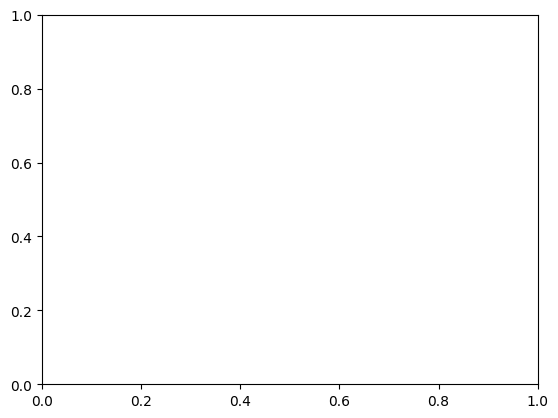

In [64]:
# create empty lists for the x and y data
x = []
y = []

# create the figure and axes objects
fig, ax = plt.subplots()

def animate(i):
    pt = randint(1,9) # grab a random integer to be the next y-value in the animation
    x.append(i)
    y.append(pt)

    ax.clear()
    ax.plot(x, y)
    ax.set_xlim([0,20])
    ax.set_ylim([0,10])
    
# run the animation
ani = FuncAnimation(fig, animate, frames=20, interval=500, repeat=False)

plt.show()

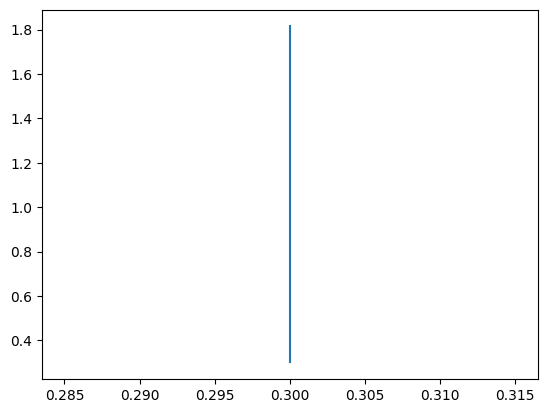

In [59]:
plt.plot(pos[:, 0], pos[:, 1])

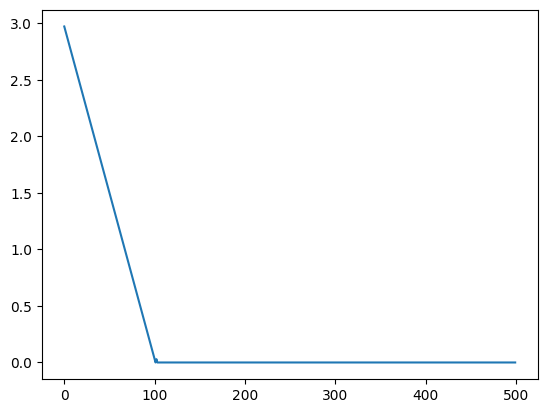

In [60]:
plt.plot(vel[1:, 1])

In [61]:
vel[:, 1] 

array([0.     , 2.97057, 2.94114, 2.91171, 2.88228, 2.85285, 2.82342,
       2.79399, 2.76456, 2.73513, 2.7057 , 2.67627, 2.64684, 2.61741,
       2.58798, 2.55855, 2.52912, 2.49969, 2.47026, 2.44083, 2.4114 ,
       2.38197, 2.35254, 2.32311, 2.29368, 2.26425, 2.23482, 2.20539,
       2.17596, 2.14653, 2.1171 , 2.08767, 2.05824, 2.02881, 1.99938,
       1.96995, 1.94052, 1.91109, 1.88166, 1.85223, 1.8228 , 1.79337,
       1.76394, 1.73451, 1.70508, 1.67565, 1.64622, 1.61679, 1.58736,
       1.55793, 1.5285 , 1.49907, 1.46964, 1.44021, 1.41078, 1.38135,
       1.35192, 1.32249, 1.29306, 1.26363, 1.2342 , 1.20477, 1.17534,
       1.14591, 1.11648, 1.08705, 1.05762, 1.02819, 0.99876, 0.96933,
       0.9399 , 0.91047, 0.88104, 0.85161, 0.82218, 0.79275, 0.76332,
       0.73389, 0.70446, 0.67503, 0.6456 , 0.61617, 0.58674, 0.55731,
       0.52788, 0.49845, 0.46902, 0.43959, 0.41016, 0.38073, 0.3513 ,
       0.32187, 0.29244, 0.26301, 0.23358, 0.20415, 0.17472, 0.14529,
       0.11586, 0.08

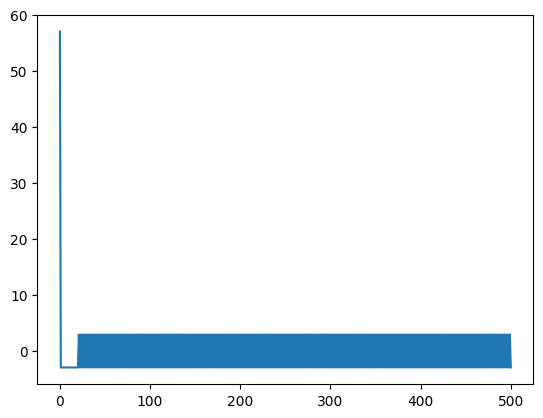

In [41]:
plt.plot(acc[:, 1])

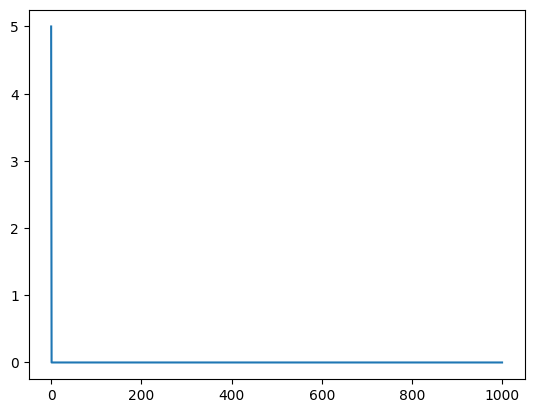

In [181]:
plt.plot(ext_force[:, 0])

In [189]:
acc[:, 0]

array([ 2.057, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
        2.943, -2.943,  2.943, -2.943,  2.943, -2.943,  2.943, -2.943,
      

In [ ]:
## Introduce a RTF calculation and display system using the time library
